# Car Price Evaluation

The used car sales service "Not Beaten, Not Painted" is developing an application to attract new customers. In it, you can quickly find out the market value of your car. You have historical data: technical characteristics, configurations, and car prices. You need to build a model to determine the price.

The customer cares about:

- prediction quality;
- prediction speed;
- training time.

**Goal: Train a model to determine the market value of a car using a gradient boosting algorithm and compare its quality and speed with simpler models.**

**Data description:**

*Features*
   * **DateCrawled** — date the listing was downloaded from the database
   * **VehicleType** — type of car body
   * **RegistrationYear** — year the car was registered
   * **Gearbox** — type of gearbox
   * **Power** — power (hp)
   * **Model** — car model
   * **Kilometer** — mileage (km)
   * **RegistrationMonth** — month the car was registered
   * **FuelType** — type of fuel
   * **Brand** — car brand
   * **Repaired** — whether the car was repaired or not
   * **DateCreated** — date the listing was created
   * **NumberOfPictures** — number of car photos
   * **PostalCode** — owner's postal code
   * **LastSeen** — date of last user activity

*Target*
   * **Price** — price (euro)

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import (
    StandardScaler, 
    OneHotEncoder, 
    OrdinalEncoder, 
    MinMaxScaler,
    LabelEncoder
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV 
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    r2_score,
    precision_score,
    recall_score,
    mean_squared_error,
    mean_absolute_error,
    roc_auc_score,
    make_scorer
)

from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import phik
import re

In [3]:
RANDOM_STATE = 44
TEST_SIZE = 0.25

## Data Preparation

### Data Loading

In [4]:
df = pd.read_csv('autos.csv', parse_dates=['DateCrawled','DateCreated','LastSeen'])
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

**Features are in the correct format, column names are in camelCase.**

In [6]:
df = df.rename(columns=lambda x: re.sub(r'(?<!^)([A-Z])', r'_\1', x).lower())
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


**Changed to snake_case.**

In [7]:
df.isnull().any()

date_crawled          False
price                 False
vehicle_type           True
registration_year     False
gearbox                True
power                 False
model                  True
kilometer             False
registration_month    False
fuel_type              True
brand                 False
repaired               True
date_created          False
number_of_pictures    False
postal_code           False
last_seen             False
dtype: bool

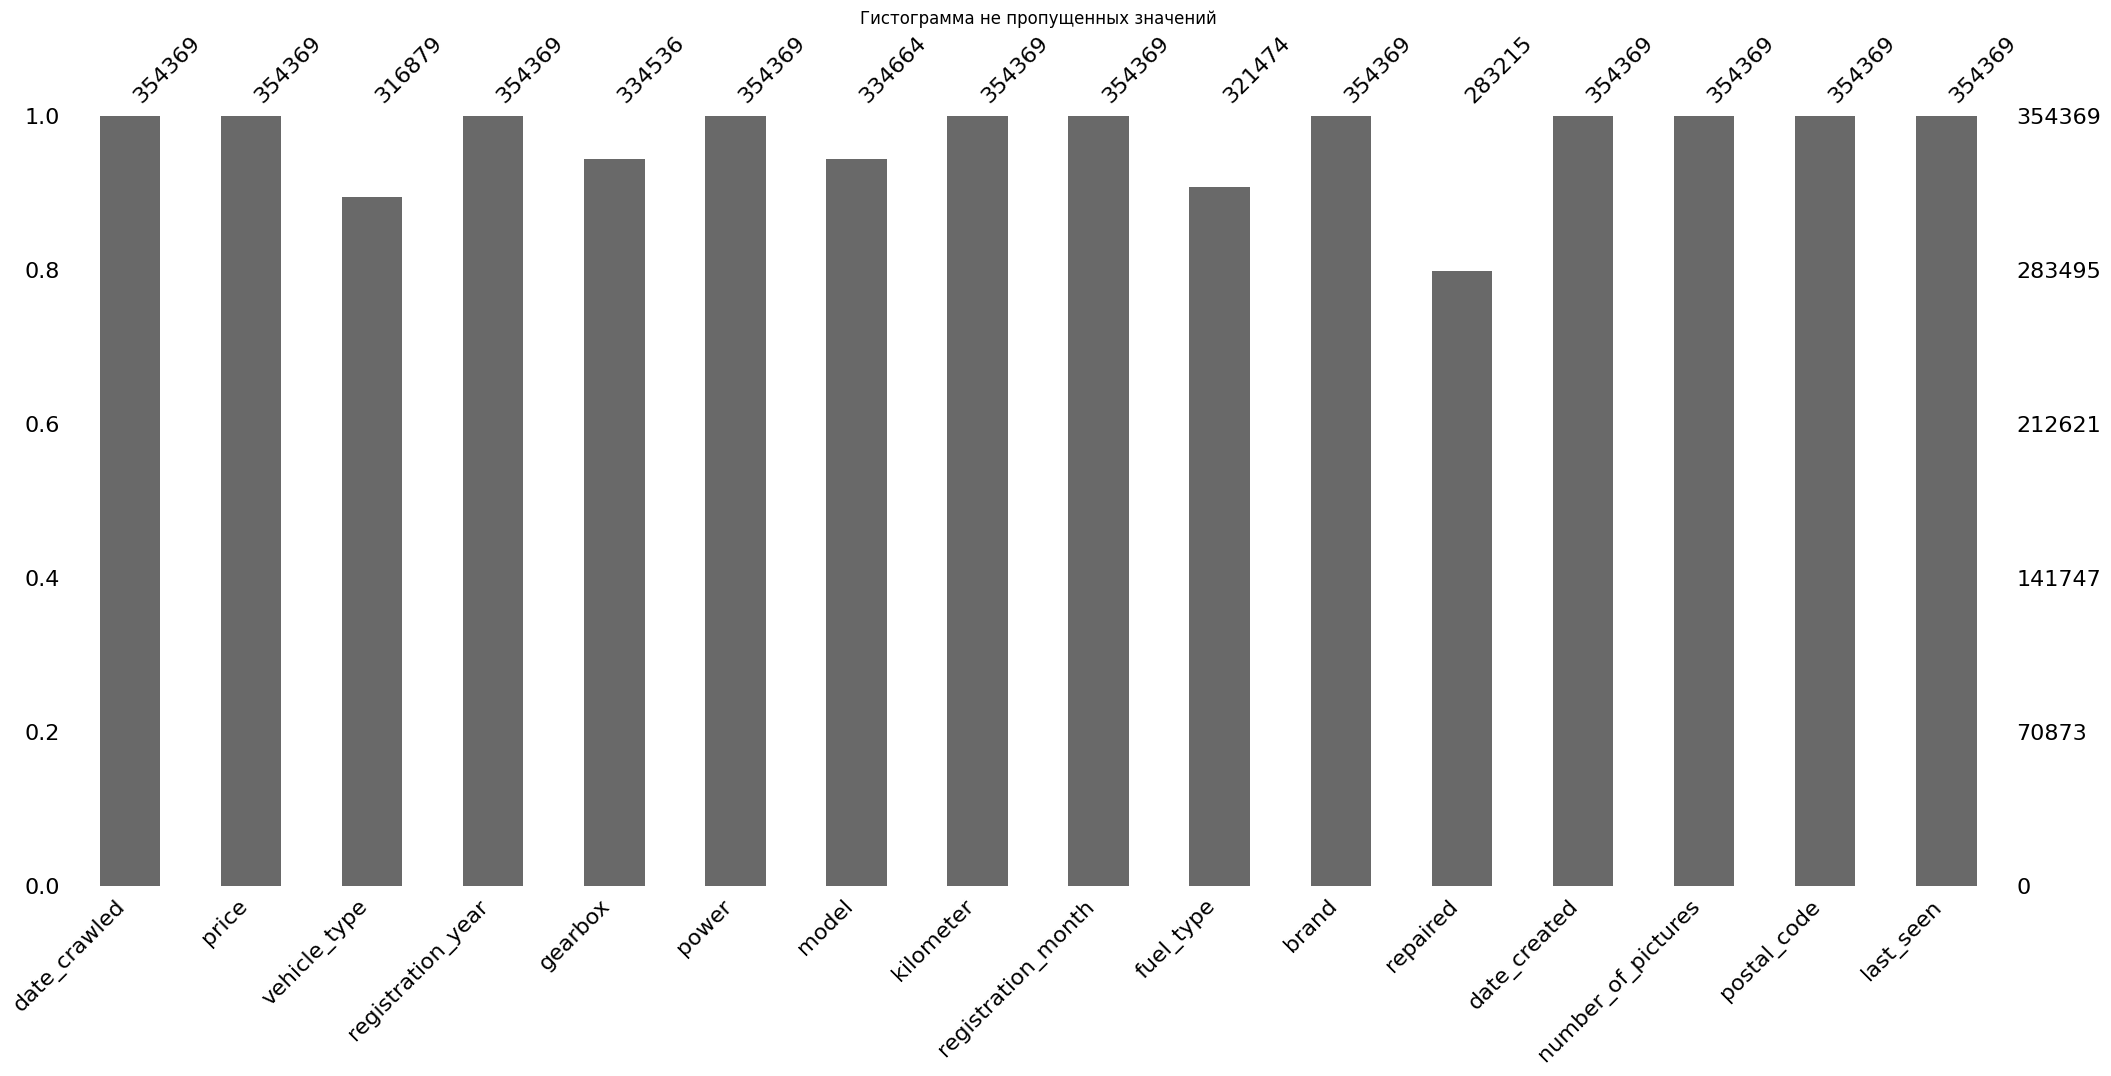

In [8]:
msno.bar(df)
plt.title("Гистограмма не пропущенных значений")
print()

**There are missing values in VehicleType, Gearbox, Model, FuelType, Repaired, most in Repaired.**

### Data Preprocessing

**First, let's look at the unique values of categorical features for typos.**

In [9]:
for col in df.loc[:, ~df.columns.isin(['date_crawled', 'date_created', 'last_seen'])].select_dtypes(exclude='number').columns:
    print(col,':',df[col].unique())

vehicle_type : [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
gearbox : ['manual' 'auto' nan]
model : ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 

**In fuel_type, "petrol" and "gasoline" are the same, replace with "gasoline".**

In [10]:
df['fuel_type'].replace(to_replace='petrol', value='gasoline', inplace=True)

**Let's look at the percentage of missing values:**

In [11]:
round(df.isnull().sum() / df.shape[0] * 100, 1).sort_values(ascending=False)

repaired              20.1
vehicle_type          10.6
fuel_type              9.3
gearbox                5.6
model                  5.6
date_crawled           0.0
price                  0.0
registration_year      0.0
power                  0.0
kilometer              0.0
registration_month     0.0
brand                  0.0
date_created           0.0
number_of_pictures     0.0
postal_code            0.0
last_seen              0.0
dtype: float64

**Immediately remove rows with missing model, try to find missing values in gear-box, vehicle_type, and fuel_type from similar brand/model combinations.**

In [12]:
df = df.dropna(subset=['model'])

In [13]:
df_nan_replace = df.groupby(['brand', 'model'])[['gearbox', 'vehicle_type', 'fuel_type']]\
.apply(pd.DataFrame.mode)
df_nan_replace = df_nan_replace.reset_index().drop('level_2', axis=1)
df_nan_replace

,brand,model,gearbox,vehicle_type,fuel_type
0,alfa_romeo,145,manual,small,gasoline
1,alfa_romeo,147,manual,sedan,gasoline
2,alfa_romeo,156,manual,wagon,gasoline
3,alfa_romeo,159,manual,wagon,gasoline
4,alfa_romeo,other,manual,sedan,gasoline
...,...,...,...,...,...
297,volvo,v40,manual,wagon,gasoline
298,volvo,v50,manual,wagon,gasoline
299,volvo,v60,manual,wagon,gasoline
300,volvo,v70,manual,wagon,gasoline


In [14]:
df = pd.merge(df, df_nan_replace, on=['brand', 'model'], how='outer', suffixes=('_old', ''))
for col in ['gearbox', 'vehicle_type', 'fuel_type']:
    df[col] = df[f'{col}_old'].combine_first(df[col])
df = df.drop(columns=[f'{col}_old' for col in ['gearbox', 'vehicle_type', 'fuel_type']])

df.head()

,date_crawled,price,registration_year,power,model,kilometer,registration_month,brand,repaired,date_created,number_of_pictures,postal_code,last_seen,gearbox,vehicle_type,fuel_type
0,2016-03-28 19:45:38,80,2000,0,145,150000,0,alfa_romeo,NaN,2016-03-28,0,24351,2016-03-30 11:18:44,manual,small,gasoline
1,2016-04-04 14:39:09,600,1998,140,145,150000,1,alfa_romeo,NaN,2016-04-04,0,34314,2016-04-06 15:46:04,manual,small,gasoline
2,2016-03-17 10:49:03,750,1999,103,145,100000,3,alfa_romeo,no,2016-03-17,0,93053,2016-04-06 09:15:41,manual,sedan,gasoline
3,2016-03-31 18:49:57,400,1997,0,145,150000,11,alfa_romeo,yes,2016-03-31,0,74842,2016-04-06 12:46:35,manual,small,gasoline
4,2016-03-24 13:49:02,333,1999,120,145,70000,2,alfa_romeo,no,2016-03-24,0,6648,2016-04-01 08:46:40,manual,small,gasoline


In [15]:
df.isna().sum()

date_crawled              0
price                     0
registration_year         0
power                     0
model                     0
kilometer                 0
registration_month        0
brand                     0
repaired              62127
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
gearbox                  14
vehicle_type              0
fuel_type                16
dtype: int64

**Filled missing values, for Repaired, since assigning a value to 20% of the dataset may distort predictions, just drop remaining missing values.**

In [16]:
#df['Repaired'] = df['Repaired'].fillna('no')
df = df.dropna()
df.isna().sum()

date_crawled          0
price                 0
registration_year     0
power                 0
model                 0
kilometer             0
registration_month    0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
gearbox               0
vehicle_type          0
fuel_type             0
dtype: int64

**Check for duplicates.**

In [17]:
df.duplicated().sum()

116

In [18]:
df = df.drop_duplicates()

In [19]:
df.duplicated().sum()

0

### Exploratory Data Analysis

**Explore numerical features for outliers and anomalies.**

In [20]:
numeric = ['price',
           'registration_year',
           'power', 
           'kilometer',
           'number_of_pictures']

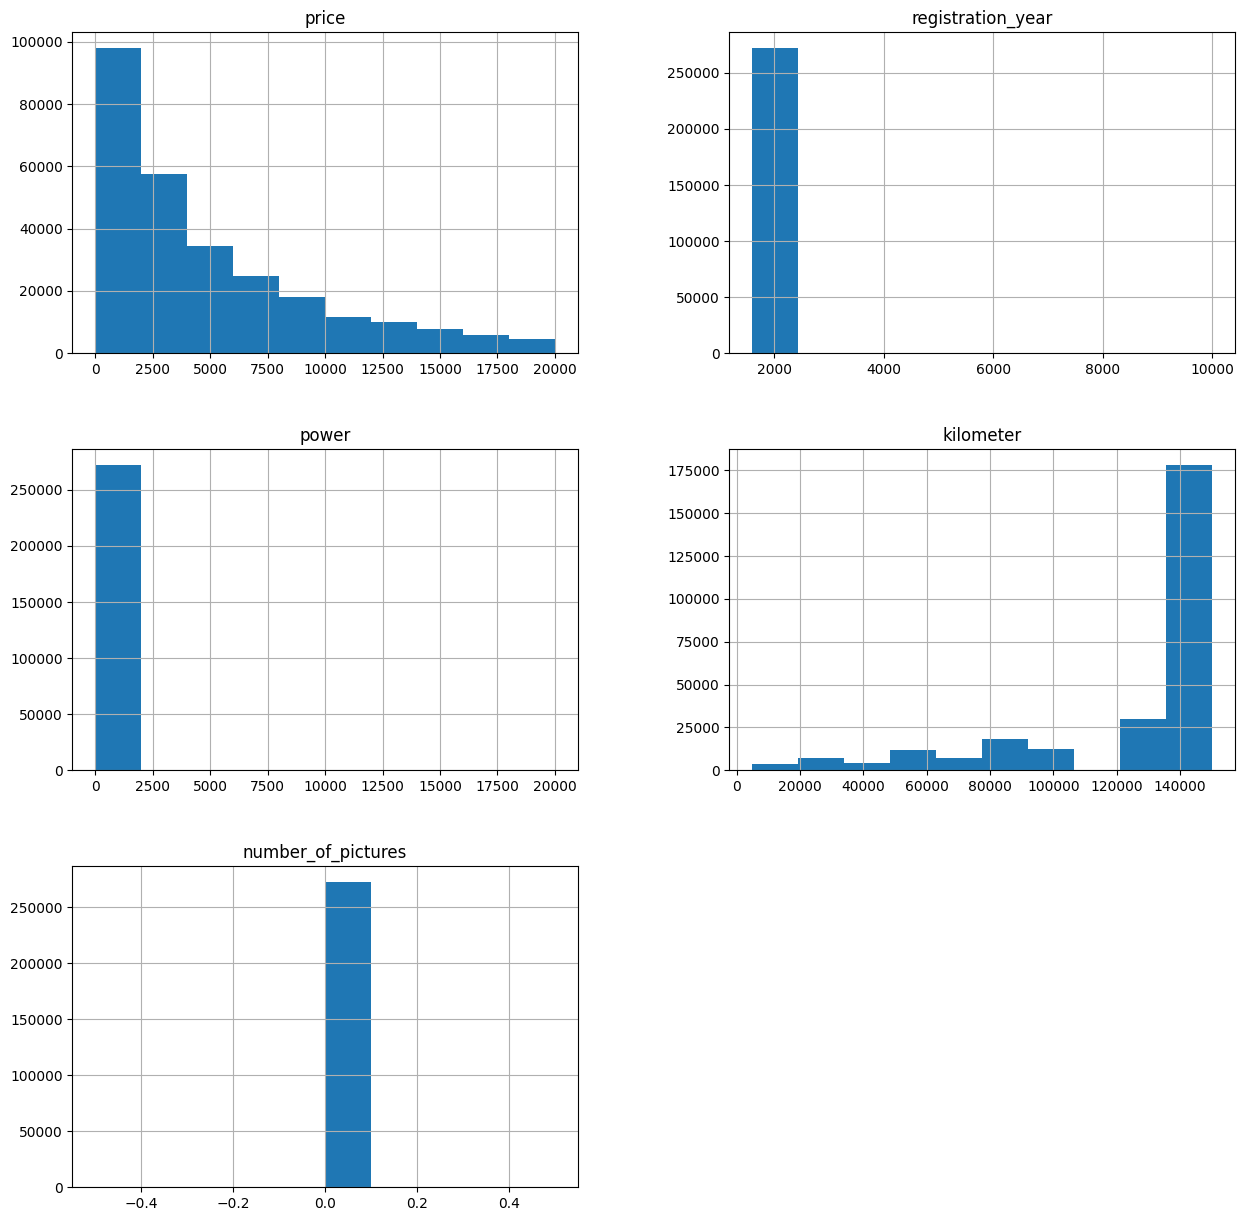

In [21]:
df[numeric].hist(figsize=(15,15))
print()

**number_of_pictures only takes value 0, drop this column.**

In [22]:
df = df.drop('number_of_pictures', axis=1)
df.head()

,date_crawled,price,registration_year,power,model,kilometer,registration_month,brand,repaired,date_created,postal_code,last_seen,gearbox,vehicle_type,fuel_type
2,2016-03-17 10:49:03,750,1999,103,145,100000,3,alfa_romeo,no,2016-03-17,93053,2016-04-06 09:15:41,manual,sedan,gasoline
3,2016-03-31 18:49:57,400,1997,0,145,150000,11,alfa_romeo,yes,2016-03-31,74842,2016-04-06 12:46:35,manual,small,gasoline
4,2016-03-24 13:49:02,333,1999,120,145,70000,2,alfa_romeo,no,2016-03-24,6648,2016-04-01 08:46:40,manual,small,gasoline
5,2016-03-28 20:51:02,600,1996,103,145,100000,8,alfa_romeo,no,2016-03-28,24217,2016-04-07 03:44:34,manual,small,gasoline
7,2016-03-29 12:56:11,125,2016,103,145,150000,8,alfa_romeo,yes,2016-03-29,82293,2016-04-05 22:46:23,manual,small,gasoline


**Look at power, registration_year in detail, likely outliers.**

In [23]:
df['power'].describe()

count    272564.000000
mean        116.698071
std         161.194553
min           0.000000
25%          75.000000
50%         109.000000
75%         147.000000
max       20000.000000
Name: power, dtype: float64

In [24]:
df.sort_values(by='power', ascending=False).head(5)

,date_crawled,price,registration_year,power,model,kilometer,registration_month,brand,repaired,date_created,postal_code,last_seen,gearbox,vehicle_type,fuel_type
139480,2016-03-09 15:43:53,4300,1999,20000,clk,150000,1,mercedes_benz,no,2016-03-09,19406,2016-03-30 08:47:08,auto,coupe,gasoline
60196,2016-03-09 08:53:11,1500,1997,19312,5er,150000,1,bmw,no,2016-03-09,21129,2016-04-07 11:44:34,manual,wagon,gasoline
56500,2016-03-25 14:55:49,2100,2001,19208,5er,150000,5,bmw,yes,2016-03-25,59556,2016-03-30 05:16:18,manual,wagon,gasoline
57943,2016-03-20 16:51:48,6000,2004,17700,5er,150000,7,bmw,no,2016-03-20,26316,2016-04-06 22:45:56,auto,wagon,gasoline
3282,2016-03-09 18:57:50,1700,1995,17410,80,5000,0,audi,yes,2016-03-09,23562,2016-03-15 07:17:06,manual,wagon,gasoline


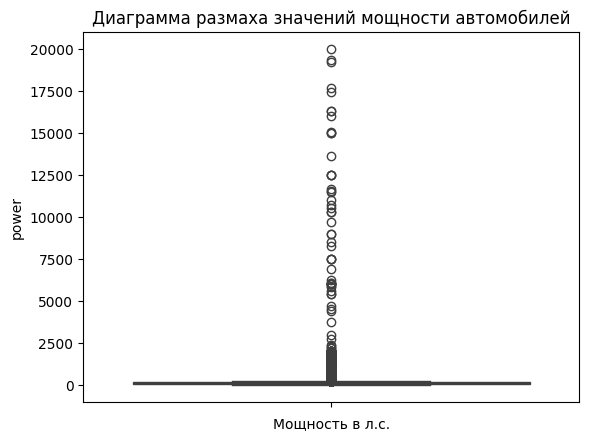

In [25]:
sns.boxplot(data=df['power'].reset_index(drop=True))
plt.xlabel('Мощность в л.с.')
plt.title('Диаграмма размаха значений мощности автомобилей');

**Many outliers, check values > 400 hp or = 0**

In [26]:
df.query('power > 400 or power < 10').sort_values(by='price', ascending=False)

,date_crawled,price,registration_year,power,model,kilometer,registration_month,brand,repaired,date_created,postal_code,last_seen,gearbox,vehicle_type,fuel_type
145452,2016-04-02 11:49:32,20000,2011,0,e_klasse,150000,7,mercedes_benz,no,2016-04-02,28717,2016-04-06 09:46:00,auto,sedan,gasoline
329879,2016-03-22 12:55:40,20000,2009,0,transporter,150000,9,volkswagen,no,2016-03-22,78315,2016-03-31 09:44:21,manual,bus,gasoline
62722,2016-03-31 17:48:20,20000,2006,507,m_reihe,150000,6,bmw,no,2016-03-31,94032,2016-04-02 13:18:22,auto,sedan,gasoline
62692,2016-03-05 18:58:19,20000,2006,507,m_reihe,150000,6,bmw,no,2016-03-05,94032,2016-03-30 21:47:45,auto,sedan,gasoline
151115,2016-04-04 11:47:12,20000,2003,500,s_klasse,80000,12,mercedes_benz,no,2016-04-04,71272,2016-04-06 12:46:20,auto,sedan,gasoline
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304847,2016-03-13 01:57:17,0,1994,0,passat,150000,6,volkswagen,no,2016-03-13,4158,2016-04-06 10:46:46,manual,wagon,gasoline
304789,2016-04-02 01:37:13,0,1995,0,passat,150000,5,volkswagen,no,2016-04-02,44359,2016-04-02 08:47:58,manual,wagon,gasoline
95313,2016-03-17 20:41:55,0,2018,0,focus,150000,10,ford,no,2016-03-17,18147,2016-03-17 20:41:55,manual,wagon,gasoline
193053,2016-03-07 09:53:32,0,2002,0,omega,150000,4,opel,yes,2016-03-07,45892,2016-04-06 20:44:57,manual,wagon,lpg


**Since it's hard to manually assess plausibility, just remove these entries.**

In [27]:
df = df.query('power <= 400 and power > 10')

In [28]:
df['power'].describe()

count    255200.000000
mean        121.358926
std          52.296211
min          11.000000
25%          80.000000
50%         115.000000
75%         150.000000
max         400.000000
Name: power, dtype: float64

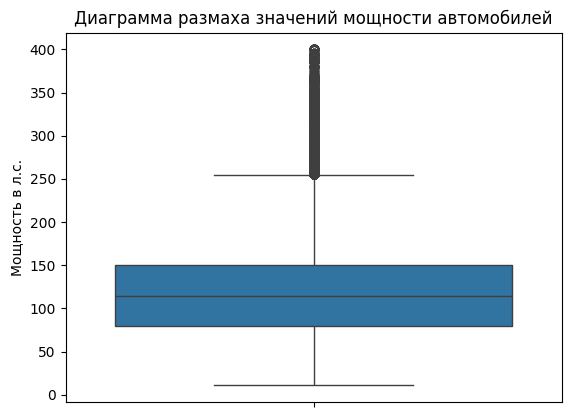

In [29]:
sns.boxplot(data=df['power'].reset_index(drop=True))
plt.ylabel('Мощность в л.с.')
plt.title('Диаграмма размаха значений мощности автомобилей');

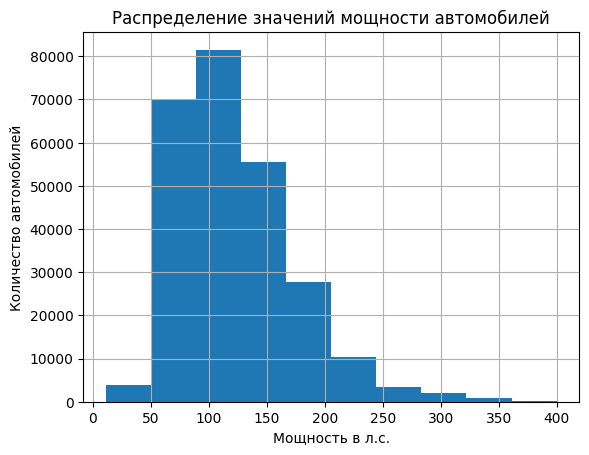

In [30]:
df['power'].hist()
plt.ylabel('Количество автомобилей')
plt.xlabel('Мощность в л.с.')
plt.title('Распределение значений мощности автомобилей');

**Leave as is, there may be sports cars with ~400 hp.**

**Next, look at registration_year.**

In [31]:
df['registration_year'].describe()

count    255200.000000
mean       2003.481995
std          17.713259
min        1910.000000
25%        1999.000000
50%        2004.000000
75%        2008.000000
max        9000.000000
Name: registration_year, dtype: float64

In [32]:
df.sort_values(by='date_crawled', ascending=False).head()

,date_crawled,price,registration_year,power,model,kilometer,registration_month,brand,repaired,date_created,postal_code,last_seen,gearbox,vehicle_type,fuel_type
141973,2016-04-07 14:36:58,3500,1999,143,e_klasse,150000,8,mercedes_benz,no,2016-04-07,64846,2016-04-07 14:36:58,manual,sedan,gasoline
115954,2016-04-07 14:36:56,8650,1992,121,wrangler,125000,5,jeep,no,2016-04-07,20357,2016-04-07 14:36:56,manual,suv,gasoline
26531,2016-04-07 14:36:55,15200,2008,190,a6,150000,9,audi,no,2016-04-07,81476,2016-04-07 14:36:55,manual,wagon,gasoline
45222,2016-04-07 14:36:53,6990,1979,143,3er,150000,6,bmw,no,2016-04-07,71336,2016-04-07 14:36:53,auto,coupe,gasoline
77068,2016-04-07 14:36:46,1500,2005,69,doblo,150000,1,fiat,no,2016-04-07,52076,2016-04-07 14:36:46,manual,bus,gasoline


**2016-04-06 is the upper limit for registration date.**

In [33]:
df.query('registration_year > 2019 or registration_year < 1970').sort_values(by='registration_year')

,date_crawled,price,registration_year,power,model,kilometer,registration_month,brand,repaired,date_created,postal_code,last_seen,gearbox,vehicle_type,fuel_type
258366,2016-03-07 22:58:46,3400,1910,90,beetle,90000,4,volkswagen,no,2016-03-07,34308,2016-03-12 08:16:51,manual,small,gasoline
194169,2016-04-03 19:47:42,0,1910,170,omega,150000,1,opel,no,2016-04-03,32425,2016-04-05 20:44:38,manual,wagon,gasoline
70245,2016-03-14 14:00:30,8750,1923,11,c3,5000,0,citroen,no,2016-03-14,27299,2016-04-05 16:44:28,manual,convertible,gasoline
63090,2016-03-09 16:52:31,11500,1929,15,other,5000,1,bmw,yes,2016-03-09,70569,2016-04-07 06:44:38,manual,convertible,gasoline
63026,2016-03-09 16:51:17,11500,1929,15,other,5000,1,bmw,yes,2016-03-09,70569,2016-04-07 06:17:11,manual,convertible,gasoline
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78102,2016-03-21 18:50:47,11000,1969,50,other,100000,5,fiat,no,2016-03-21,35759,2016-04-05 19:47:58,manual,convertible,gasoline
194612,2016-04-03 16:44:50,5222,1969,90,other,90000,7,opel,no,2016-04-03,29525,2016-04-05 15:46:59,manual,sedan,gasoline
212939,2016-03-10 14:51:00,2000,1969,76,4_reihe,70000,3,peugeot,no,2016-03-10,26871,2016-04-07 13:16:43,manual,sedan,gasoline
213712,2016-03-15 04:36:17,1,6500,120,other,10000,9,peugeot,no,2016-03-15,13409,2016-03-23 14:16:33,manual,bus,gasoline


**Remove years before 1970 and after 2016 as implausible and rare.**

In [34]:
df = df.query('registration_year <= 2016 and registration_year >= 1970')

''

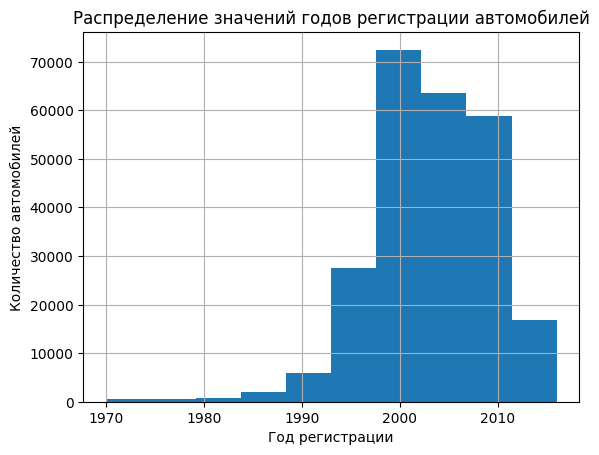

In [ ]:
df['registration_year'].hist()
plt.ylabel('Количество автомобилей')
plt.xlabel('Год регистрации')
plt.title('Распределение значений годов регистрации автомобилей');

**Now look at the target Price.**

In [36]:
df['price'].describe()

count    249088.000000
mean       5083.482320
std        4694.663287
min           0.000000
25%        1450.000000
50%        3499.000000
75%        7490.000000
max       20000.000000
Name: price, dtype: float64

In [37]:
df.query('price < 100')

,date_crawled,price,registration_year,power,model,kilometer,registration_month,brand,repaired,date_created,postal_code,last_seen,gearbox,vehicle_type,fuel_type
186,2016-03-25 10:36:20,0,2002,105,147,125000,3,alfa_romeo,yes,2016-03-25,95152,2016-04-06 09:45:32,manual,small,gasoline
364,2016-03-25 11:48:36,0,2002,150,147,150000,3,alfa_romeo,yes,2016-03-25,66424,2016-04-04 11:44:40,manual,coupe,gasoline
651,2016-03-10 22:36:21,0,1998,150,156,150000,1,alfa_romeo,yes,2016-03-10,84088,2016-03-11 07:43:34,manual,sedan,gasoline
683,2016-03-16 19:52:39,0,1998,145,156,150000,9,alfa_romeo,no,2016-03-16,96268,2016-03-20 20:49:02,manual,sedan,gasoline
698,2016-03-21 18:43:22,0,1999,136,156,150000,1,alfa_romeo,yes,2016-03-21,72131,2016-04-06 19:47:45,manual,sedan,gasoline
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334134,2016-03-29 07:36:18,0,1999,265,v70,150000,5,volvo,no,2016-03-29,59071,2016-03-29 08:56:09,auto,wagon,gasoline
334178,2016-03-28 18:59:11,0,1998,192,v70,150000,8,volvo,no,2016-03-28,49696,2016-04-01 04:46:04,manual,wagon,gasoline
334377,2016-04-02 15:43:47,0,1998,192,v70,150000,5,volvo,no,2016-04-02,49692,2016-04-06 14:16:50,manual,wagon,gasoline
334399,2016-03-06 13:47:26,0,1997,144,v70,150000,2,volvo,yes,2016-03-06,88239,2016-04-06 05:46:27,manual,wagon,gasoline


**Since the model doesn't need to decide if a car should be given away for free, just remove these entries.**

In [38]:
df = df.query('price >= 100')

In [39]:
df.shape[0]

244793

**After filtering, 250,000 entries remain.**

### Correlation Analysis

**Do a simple correlation analysis, plot a heatmap of phi_k correlation coefficients.**

In [40]:
df.select_dtypes(include='number').columns

Index(['price', 'registration_year', 'power', 'kilometer',
       'registration_month', 'postal_code'],
      dtype='object')

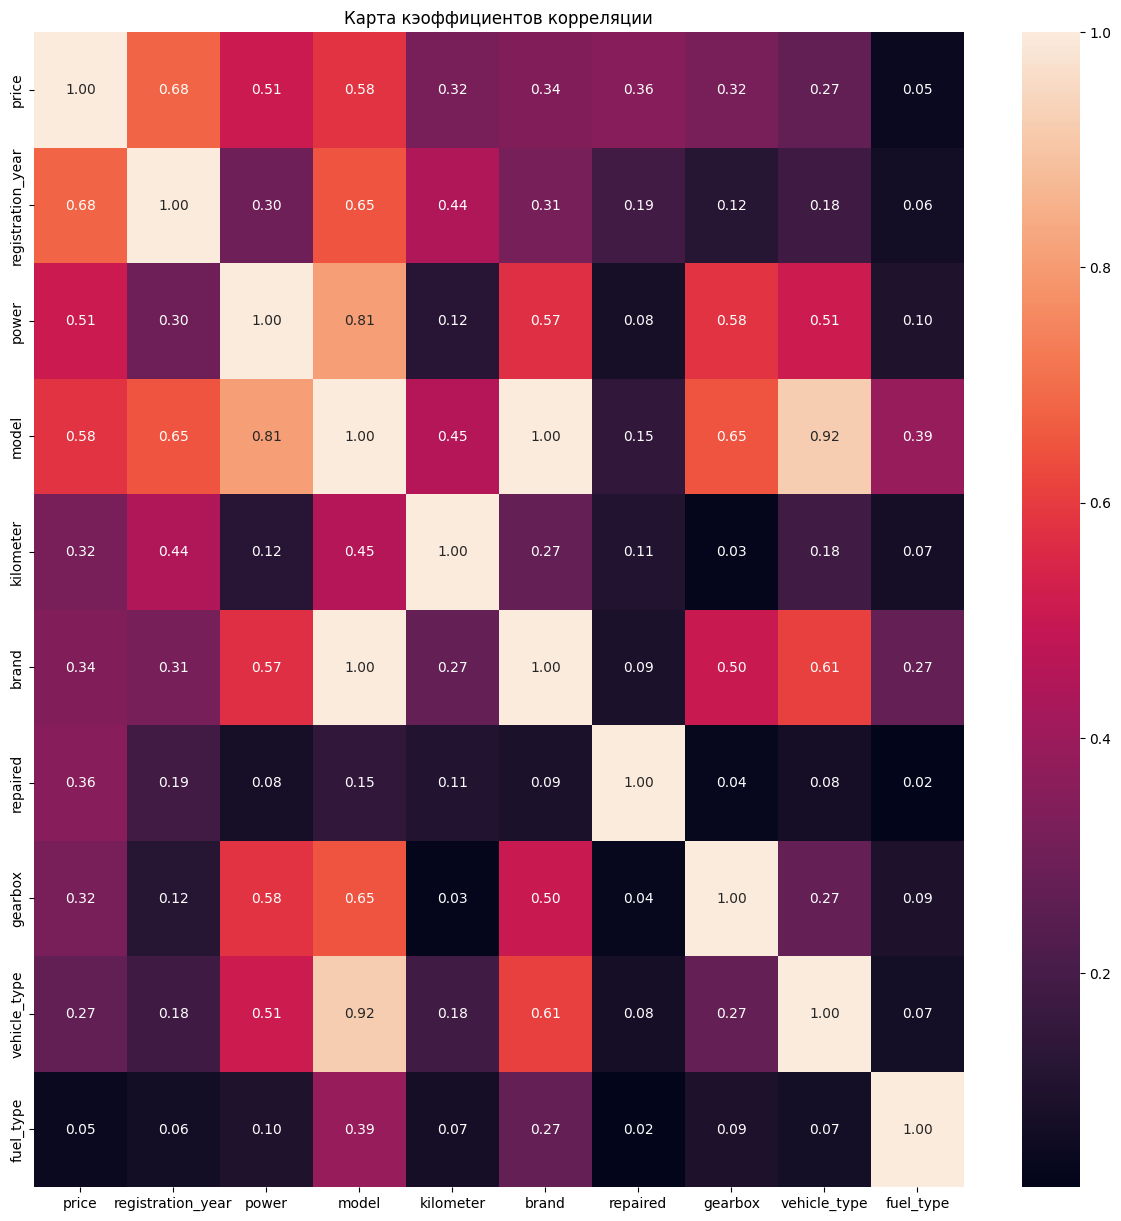

In [41]:
interval_cols = ['price', 
                 'registration_year', 
                 'power', 
                 'kilometer',
                 'registration_month']

to_drop = ['postal_code',
           'last_seen',
           'date_crawled',
           'date_created',
           'registration_month']

fig, ax = plt.subplots(figsize=(15,15))
plt.title('Карта кэоффициентов корреляции')
sns.heatmap(df.drop(to_drop, axis=1).phik_matrix(interval_cols=interval_cols),
            annot=True, 
            fmt='.2f',
            ax=ax) 
print()

**Most correlated with Price are RegistrationYear, Model, and Power. Brand and Model are highly correlated, keep only Brand.**

In [42]:
df = df.drop(to_drop, axis=1).reset_index(drop=True)

**Data preprocessing summary: Dates converted to correct type, columns renamed to snake_case, dropped non-informative number_of_pictures. Outliers and anomalies filtered, duplicates removed. Correlation analysis showed strong correlation between brand and model (logical).**

## Model Training

**We will use LightGBM and LinearRegression. Hyperparameter search will be done in a pipeline.**

**First, select features for training and those to scale/encode.**

In [43]:
df.select_dtypes(exclude='number').columns

Index(['model', 'brand', 'repaired', 'gearbox', 'vehicle_type', 'fuel_type'], dtype='object')

In [44]:
df.select_dtypes(include='number').columns

Index(['price', 'registration_year', 'power', 'kilometer'], dtype='object')

In [45]:
ohe_columns = ['repaired', 'brand', 'vehicle_type', 'gearbox', 'fuel_type']
num_columns = ['registration_year', 'power', 'kilometer']
df[ohe_columns] = df[ohe_columns].astype('category')

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244793 entries, 0 to 244792
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              244793 non-null  int64   
 1   registration_year  244793 non-null  int64   
 2   power              244793 non-null  int64   
 3   model              244793 non-null  object  
 4   kilometer          244793 non-null  int64   
 5   brand              244793 non-null  category
 6   repaired           244793 non-null  category
 7   gearbox            244793 non-null  category
 8   vehicle_type       244793 non-null  category
 9   fuel_type          244793 non-null  category
dtypes: category(5), int64(4), object(1)
memory usage: 10.5+ MB


**Split data into train and test sets.**

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['price', 'model'], axis=1),
    df['price'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

X_train.shape, X_test.shape

((183594, 8), (61199, 8))

**Start creating pipelines for scaling and encoding.**

In [48]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))
    ]
    )

**Combine pipelines for feature processing.**

In [49]:
data_preprocessor_ridge = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

**Create the final pipeline.**

In [50]:


pipe_final_ridge = Pipeline([
    ('preprocessor', data_preprocessor_ridge),
    ('models', Ridge())
])

**Create a dictionary with models and hyperparameters for search.**

In [51]:
model = lgb.LGBMRegressor(n_estimators=20, num_leaves=70,
                                 verbose=3,
                                 random_state=RANDOM_STATE)
param_grid_lgbm = [
    {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [5, 10, 15]
          
    }]
param_grid_ridge = [    
    {
        'models': [Ridge()],
        'models__alpha': [0.1, 0.5, 1, 2.5, 3.5,  5, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    }
]

**Create custom RMSE metric.**

In [52]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [53]:
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [54]:
%%time
grid_search_ridge = GridSearchCV(
    pipe_final_ridge,
    param_grid_ridge,
    scoring=rmse_scorer,
    cv=3,
    n_jobs=-1
)
grid_search_ridge.fit(X_train, y_train)

CPU times: total: 1.33 s
Wall time: 5.11 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse_output=False))]),
                                                                         ['repaired',
                                                                          'brand',
                                                                          'vehicle_type',
                                                                          'gearbox',
                                                                          'fuel_type']),
                                                                        ('num',
                                                                         MinMaxScaler(),
                                                                         ['registration_year',
                                                                          'power',
                                                                          'kilometer'])])),
                                       ('models', Ridge())]),
             n_jobs=-1,
             param_grid=[{'models': [Ridge()],
                          'models__alpha': [0.1, 0.5, 1, 2.5, 3.5, 5, 10],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler()]}],
             scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'))

In [55]:
grid_search_ridge.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['repaired', 'brand',
                                                   'vehicle_type', 'gearbox',
                                                   'fuel_type']),
                                                 ('num', StandardScaler(),
                                                  ['registration_year', 'power',
                                                   'kilometer'])])),
                ('models', Ridge(alpha=1))])

In [56]:
print('Лучшая модель и её параметры:\n\n', grid_search_ridge.best_estimator_)
print ('Метрика лучшей модели на валидационной выборке:', grid_search_ridge.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['repaired', 'brand',
                                                   'vehicle_type', 'gearbox',
                                                   'fuel_type']),
                                                 ('num', StandardScaler(),
                                                  ['reg

In [57]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183594 entries, 37898 to 14100
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   registration_year  183594 non-null  int64   
 1   power              183594 non-null  int64   
 2   kilometer          183594 non-null  int64   
 3   brand              183594 non-null  category
 4   repaired           183594 non-null  category
 5   gearbox            183594 non-null  category
 6   vehicle_type       183594 non-null  category
 7   fuel_type          183594 non-null  category
dtypes: category(5), int64(3)
memory usage: 6.5 MB


In [58]:
%%time
grid_search_lgbm = GridSearchCV(
    model,
    param_grid_lgbm,
    scoring=rmse_scorer,
    cv=3,
    n_jobs=-1
)
grid_search_lgbm.fit(X_train, y_train)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.888195
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.345916
[LightGBM] [Debug] init for col-wise cost 0.004464 seconds, init for row-wise cost 0.014034 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 183594, number of used features: 8
[LightGBM] [Info] Start training from score 5174.828273
[LightGBM] [Debug] Trained a tree with leaves = 70 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 70 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 70 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 70 and depth = 8
[LightGBM] [Debug] Trained a 

GridSearchCV(cv=3,
             estimator=LGBMRegressor(n_estimators=20, num_leaves=70,
                                     random_state=44, verbose=3),
             n_jobs=-1,
             param_grid=[{'learning_rate': [0.01, 0.05, 0.1],
                          'max_depth': [5, 10, 15]}],
             scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'))

In [59]:
grid_search_lgbm.best_estimator_

LGBMRegressor(max_depth=15, n_estimators=20, num_leaves=70, random_state=44,
              verbose=3)

In [60]:
print('Лучшая модель и её параметры:\n\n', grid_search_lgbm.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search_lgbm.best_score_)

Лучшая модель и её параметры:

 LGBMRegressor(max_depth=15, n_estimators=20, num_leaves=70, random_state=44,
              verbose=3)
Метрика лучшей модели на тренировочной выборке: -1893.406857639754


**Hyperparameter tuning for LGBM regressor took 12 seconds, for Ridge regression 6 seconds, but RMSE on train for LGBM is much better (1893) than Ridge (2720).**

## Model Analysis

**Now train the model with best hyperparameters on train data and check training speed, test quality, and prediction time.**

**First, scale data with StandartScaler and pass categorical feature names to the model.**

In [61]:
scaler = MinMaxScaler()

X_train[num_columns] = scaler.fit_transform(X_train[num_columns])
X_test[num_columns] = scaler.transform(X_test[num_columns])

In [62]:
best_model_lgbm = lgb.LGBMRegressor(n_estimators = 20,
                                    num_leaves=70,
                                    max_depth=10,
                                    n_jobs=-1,
                                    categorical_feature=ohe_columns,
                                    verbose=-1,
                                    random_state=RANDOM_STATE)

In [63]:
%%time

best_model_lgbm.fit(X_train, y_train)

C:\Users\datre\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:1873: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\datre\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:1893: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


CPU times: total: 3.16 s
Wall time: 286 ms


LGBMRegressor(categorical_feature=['repaired', 'brand', 'vehicle_type',
                                   'gearbox', 'fuel_type'],
              max_depth=10, n_estimators=20, n_jobs=-1, num_leaves=70,
              random_state=44, verbose=-1)

**LGBM model training took 0.5 seconds.**

In [64]:
%%time

lgbm_pred = best_model_lgbm.predict(X_test)

CPU times: total: 312 ms
Wall time: 59.4 ms


**LightGBM prediction takes 121 ms.**

In [65]:
print ('Метрика RMSE лучшей LGBM модели на тестовой выборке:', rmse(y_test, lgbm_pred))

Метрика RMSE лучшей LGBM модели на тестовой выборке: 1877.6690646152535


**LGBM showed required rmse <2500**

**Summary:**
   * The dataset was obtained and processed. Data types were corrected, missing values filled/removed, anomalies handled.
   * Correlation analysis was performed, non-informative and highly correlated features dropped.
   * Train and test sets created, two models compared: sklearn Ridge and LightGBM Regressor.
   * Pipelines for hyperparameter search: Ridge regularization alpha and LightGBM tree leaves and learning rate.
   * Ridge input data scaled and OHE encoded for categoricals.
   * LightGBM used OrdinalEncoder for categoricals, numerics scaled.
   * Custom RMSE metric used for model training.
   * Models trained with RandomizedSearchCV (LightGBM) and GridSearchCV (Ridge), best hyperparameters selected.
   * LightGBM trained faster and showed better metric than Ridge.
   * RMSE for LightGBM = 1875, which is satisfactory for the customer.